In [1]:
### main pipeline for data preprocessing

In [2]:
import numpy as np
import pandas as pd
import math
from scipy import stats

from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

## Pipeline Architecture

### Data-Preprocessing architecture

<ol>
    <li> Generate some form of similarity between Laws using pretrained models such as word2vec or glove. </li>
    <li> Perform Knn clustering for all laws based on (1) </li>
    <li> From m clusters generated by (2) where m = number of laws / k neighbors, load up set of keys for each cluster indicated by a dictionary appended to the cluster. For example, cluster 0 with k laws indicated by a list of dictionary should have a key for all associated keys within cluster 0 consisting of meta-data for each law such as year + state.</li>
    <li> From (3), load up all occurances in the technology descriptors for cluster i as a list. </li>
    <li> From (4), measure changes based on some metric of interest.</li>
    <li> Classify (4) as +1 (excitatory) or 0 (inhibitory). </li>
    <li> Repeat (4) and (5) for all clusters and append the label to the refined dataset. </li>    
</ol>


### Model Pipeline

<ol>
    <li> Obtain a dataset with features corresponding to law text, some technology descriptors, corresponding labels, and a user input metric of interest. </li>
    <li> Train the Model. </li>
    <li> Run Attributions. </li>
    <li> In parallel, run ACC tests on (1) </li>
    <li> Publish the model. </li>
</ol>

In [3]:
### Similarity Matrix generation - 1

In [4]:
df_laws = pd.read_csv('law_data.csv', index_col=False)
df_laws = df_laws.dropna()
del df_laws['Unnamed: 0']

### 1. Law text embeddings

In [5]:
from nltk.corpus import stopwords
import nltk
#nltk.download('stopwords')
import re
from nltk.stem.porter import *
stemmer = PorterStemmer()
import os
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances

#### Clean and preprocess policy texts

In [6]:
def law_to_words(raw_review):
    
    # 1. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", raw_review) 
    #letters_only = re.sub("[^a-zA-Z0-9]", " ", raw_review)
    
    # 2. Convert to lower case, split into individual words
    words = letters_only.lower().split()
    
    # 3. Remove Stopwords. In Python, searching a set is much faster than searching a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    
    # 4. Remove stop words
    meaningful_words = [w for w in words if not w in stops]  #returns a list 

    # 5. Stem words. Need to define porter stemmer above
    #singles = [stemmer.stem(word) for word in meaningful_words]
    
    # 6. Join the words back into one string separated by space, and return the result.
    return( " ".join(meaningful_words))

In [7]:
df_clean = pd.DataFrame([law_to_words(str(text)) for text in df_laws['StateCode'].tolist()], columns=['texts'])

#### tf-idf values for future weighting

In [8]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(df_clean.texts)
tfidf_vectors = tfidf_vectorizer.transform(df_clean.texts)

#### Calculate GloVe embeddings

In [9]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [10]:
# tokenize and pad each law to make them of equal size

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_clean.texts)
tokenized_documents = tokenizer.texts_to_sequences(df_clean.texts)
tokenized_paded_documents = pad_sequences(tokenized_documents,maxlen=None,padding='post')
vocab_size = len(tokenizer.word_index) + 1
print(len(tokenized_paded_documents))

826


In [11]:
# reading Glove word embeddings into a dictionary with "word" as key and values as word vectors
embeddings_index = dict()

In [12]:
with open('glove.6B.100d.txt', encoding='utf-8') as file:
    for line in file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
        
print(len(embeddings_index))

400000


In [13]:
# creating embedding matrix, every row is a vector representation from the vocabulary indexed by the tokenizer index. 

embedding_matrix = np.zeros((vocab_size,100))

In [14]:
for word,i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [15]:
# calculating average of word vectors of a document weighted by tf-idf

document_embeddings = np.zeros((len(tokenized_paded_documents),100))
words = tfidf_vectorizer.get_feature_names()

print(len(words))

4520


In [16]:
# instead of creating document-word embeddings, directly creating document embeddings

#print(len(tokenizer.word_index))
#print(tfidf_vectors[0, 2341])

for i in range(df_clean.shape[0]):
    for j in range(len(words)):
        document_embeddings[i] += embedding_matrix[tokenizer.word_index[words[j]]]*tfidf_vectors[i,j]

In [17]:
# calculate cosine similarity and euclidean distance pairwise

pairwise_similarities = cosine_similarity(document_embeddings)
pairwise_differences = euclidean_distances(document_embeddings)

In [18]:
residue = pairwise_similarities - pairwise_differences

In [19]:
LAWS = np.array(df_laws)

In [20]:
matrix = pairwise_similarities

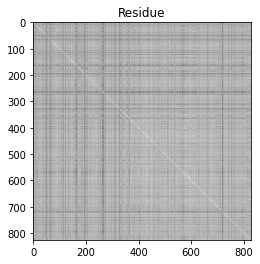

In [61]:
plt.title("Residue")
plt.imshow(residue, cmap='gray')
plt.show()

In [22]:
### Clustering - 2

In [23]:
K = 4 #number of datapoints per subset

In [24]:
def get_cluster(index, data, k):
    """Generates an index cluster of size (k+1) on a similarity dataset of shape nxn with index of interest"""
    sorted_indices = np.argsort(-data[index])
    return sorted_indices[1:k+1] #returns a cluster of indices from `data`

In [25]:
def knn(data, k):
    """Runs the Knn algorithm with k neighbors where each cluster is of size k+1 on a similarity dataset of nxn"""
    clusters = []
    for i,_ in enumerate(data):
        clusters.append(get_cluster(i, data, k))
    return clusters

In [26]:
clusters = knn(matrix, K) #generate neighborhood clusters, each of size K

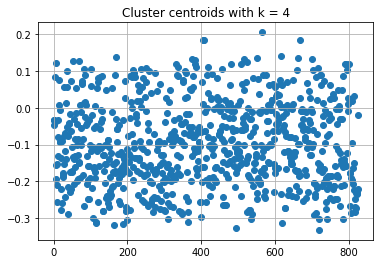

In [63]:
plt.title(f"Cluster centroids with k = {K}")
plt.scatter(np.arange(len(clusters)), [document_embeddings[x].mean() for x in clusters])
plt.grid()
plt.show()

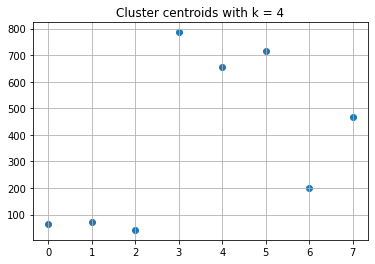

In [60]:
plt.title(f"Cluster centroids with k = {K}")
plt.scatter(np.arange(4*len(clusters[:2])), clusters[:2])
plt.grid()
plt.show()

In [28]:
### Subsectioning - 3

In [29]:
metric_of_interest = 'broadband data' #user-defined
df = pd.read_csv('../technology_descriptors/broadband-Table 1.csv', index_col=False)

In [30]:
### Measure change in features - 5

In [31]:
def measure_change(data, arr):
    """Measures net change for an individual state and returns a net gain/loss value"""
    net = 0
    for i in range(1, len(data)):
        prev, curr = float(data[i-1][:-1]), float(data[i][:-1])
        net += curr - prev
        arr[-1].append(prev)
    return int(net) #net measures overall change

In [32]:
def gains(data, arr):
    """Computes gain for all states"""
    data = np.array(data.loc[::])
    net_change = []
    for row in data:
        graph_trend.append([])
        net_change.append(measure_change(row[2:], arr))

    #averaging makes no sense! half points 0, other half 1. mode better alternative.
    #need to relax conditions and perform duality of points for comparison.
    net_change = np.array(net_change)
    tau = stats.mode(net_change)[0]
    net_change[net_change <= tau] = 0
    net_change[net_change > tau] = 1

    return np.array(net_change)

In [33]:
graph_trend = []
net_change = gains(df, graph_trend)

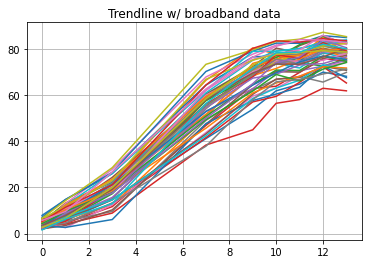

In [34]:
plt.title(f"Trendline w/ {metric_of_interest}")
plt.plot(np.array(graph_trend).T)
plt.grid()
plt.show()

In [35]:
df['change'] = net_change

In [36]:
df.head()

,state,abbreviation,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,change
0,Alabama,AL,2.1%,5.5%,10.2%,14.8%,21.4%,28.0%,34.6%,41.2%,47.6%,53.9%,61.9%,64.8%,70.0%,68.2%,70.4%,0
1,Alaska,AK,4.8%,13.3%,17.9%,22.5%,33.5%,44.5%,55.5%,66.5%,73.5%,80.5%,77.8%,77.0%,82.7%,82.3%,85.8%,1
2,Arizona,AZ,5.2%,12.9%,17.7%,22.5%,30.7%,38.9%,47.1%,55.3%,62.5%,69.6%,78.3%,74.2%,72.6%,75.8%,78.2%,0
3,Arkansas,AR,1.9%,4.5%,8.8%,13.2%,20.3%,27.4%,34.5%,41.6%,49.3%,57.1%,59.5%,65.6%,72.4%,65.3%,69.0%,0
4,California,CA,5.8%,12.1%,17.4%,22.7%,31.7%,40.6%,49.5%,58.5%,64.2%,69.9%,75.4%,75.1%,79.6%,80.2%,82.7%,0


In [37]:
### generate subset - 4

In [38]:
def get_subset(data, cluster):
    """
    Generates a subset of technology descriptors based on a cluster of laws. The output is change on states.
    - data: dataframe object coresponding to tech descriptor.
    - cluster: list of indices corresponding to LAWS array.
    """
    subset = {}
    num_pos = 0
    for index in cluster:
        #this assumes that there exists only 1 tech. descriptor per state
        change = np.array(data.loc[data.state == LAWS[index][1]]['change'])[0]
        subset[LAWS[index][1]] = change
        if change:
            num_pos += 1
    return subset, num_pos > K - num_pos #subsets, cluster label

In [39]:
#### Classify all laws as +1/0 - 6 & 7

In [40]:
def label_data(data, num_laws, subsets):
    """Labels all laws as Excitatory or Inhibitory based on some technology descriptor `data`."""
    labels = [-1]*num_laws #-1 indicates laws with no label. will not exist
    for subset in subsets:
        _, label = get_subset(data, subset)
        for i in subset:
            labels[i] = label
    return np.array(labels).reshape(num_laws, 1)

In [41]:
labels = label_data(df, len(LAWS), clusters)

In [42]:
LAWS = np.column_stack((LAWS, labels)) ### all laws labeled

In [43]:
df_labeled_laws = pd.DataFrame(LAWS, columns=list(df_laws.columns) + ['label'])

In [44]:
df_labeled_laws.head()

,Header,State,Year,Title,Category,Topic,Summary,StateCode,label
0,Ala. Code 37-16-1 et seq.,Alabama,2019,Broadband Using Electric Easements Accessibili...,Category: Competition and regulation,Topic: Cooperatives,Allows electric utilities to also provide broa...,(a) To the extent not otherwise authorized by ...,0
1,Ala. Code 37-16-2,Alabama,2019,Broadband Using Electric Easements Accessibili...,Category: Other,Topic: Legislative intent,Declares that the state intends to encourage t...,(a) The Legislature finds and declares the fol...,0
2,Ala. Code 37-16-3,Alabama,2019,Broadband Using Electric Easements Accessibili...,Category: Definitions,Topic: Definition - Broadband (As defined by F...,"Defines ""advanced communications capabilities""...",(l) Advanced Communications Capabilities. The ...,0
3,Ala. Code 37-16-3,Alabama,2019,Broadband Using Electric Easements Accessibili...,Category: Definitions,Topic: Definition - Broadband (Other speed),Defines broadband as an internet connection th...,(5) Broadband Services. The provision of conne...,0
4,Ala. Code 37-16-7,Alabama,2019,Broadband Using Electric Easements Accessibili...,Category: Infrastructure access,Topic: Right of way (Easements),Specifies the terms under which a property own...,(a) If the owner of an interest in real proper...,0


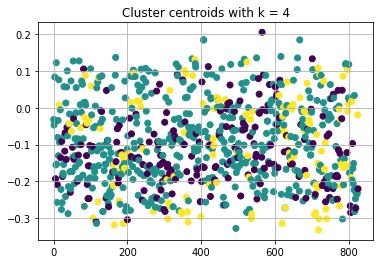

In [65]:
plt.title(f"Cluster centroids with k = {K}")
plt.scatter(np.arange(len(clusters)), [document_embeddings[x].mean() for x in clusters], c=labels)
plt.grid()
plt.show()

In [46]:
counter = [0]*3
for y in labels:
    counter[y[0] + 1] += 1
print(f"Label undefined: {counter[0]}\nInhibitory: {counter[1]}\nExcitatory: {counter[2]}")

Label undefined: 203
Inhibitory: 493
Excitatory: 130


In [47]:
### DONE. Data Pipeline